In [1]:
# Contributors:
# Richard C. (Rick) Gerkin converted the RMarkdown file used in the manuscript to a Python version
# See the original RMarkdown file for details on the original design and implementation of the analyses in R

In [2]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency, levene, ttest_1samp, ttest_ind
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sns.set(font_scale=1.5)
pd.set_option('mode.chained_assignment', None)  # Ignore SettingOnCopy warning

## Data loading and cleaning

See preanalysis.ipynb for cleaning steps

In [3]:
# Cleaned data sent to Rick by Valentina on May 13th, 2020
d = pd.read_csv('../data/data_GCCR001.csv', index_col=0)
n_initial = d.shape[0]

In [4]:
# Rename variables 
# - Clinical exam -> Clinical assessment
# - Nasal_occlusion_change -> Nasal_obstruction_change
d = d.replace({'Clinical exam': 'Clinical assessment'})
d = d.rename(columns={'Nasal_occlusion_change': 'Nasal_obstruction_change',
                      'Chemethesis_before_illness': 'Chemesthesis_before_illness'})

In [5]:
# Add indicators
d = d.join(pd.get_dummies(d[['Group']]))

## METHODS

In [6]:
def contingency_table(d, columns):
    table = d.groupby(columns).count().mean(axis=1).astype(int).unstack(columns[0])
    chi2, p, _, _ = chi2_contingency(table)
    print("χ2 = %.3g; p = %.3g" % (chi2, p))
    table['Total'] = table.sum(axis=1)
    return table

In [7]:
# Participants
contingency_table(d, ['Group', 'Gender'])

χ2 = 15.4; p = 0.0015


Group,Clinical assessment,Lab test,Total
Gender,,,
Female,1849,1064,2913
Male,783,335,1118
Other,2,1,3
Prefer not to say,3,2,5


In [8]:
# TODO: Replace with only age when I get that data
d.describe().drop('count')

,COVID_diagnosis,Age,Smell_change,Taste_change,Chemesthesis_change,Nasal_obstruction_change,smell_loss,parosmia,phantosmia,smell_fluctuations,...,Smell_before_illness,Smell_during_illness,Blocked_nose_before_illness,Blocked_nose_during_illness,Taste_before_illness,Taste_during_illness,Chemesthesis_before_illness,Chemesthesis_during_illness,Group_Clinical assessment,Group_Lab test
mean,1.359990,41.377569,-79.668235,-68.953899,-37.327507,22.356648,0.861352,0.075514,0.083436,0.133944,...,90.449369,10.781134,9.663085,32.019733,91.561773,22.607873,84.529785,47.202278,0.652884,0.347116
std,0.506172,12.202997,28.679561,32.626461,36.161968,32.366458,0.345622,0.264251,0.276575,0.340634,...,15.201447,23.614022,18.229319,31.941398,13.636754,29.145685,19.977878,32.176347,0.476112,0.476112
min,1.000000,19.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,32.000000,-99.100000,-95.700000,-69.550000,0.000000,1.000000,0.000000,0.000000,0.000000,...,86.000000,0.000000,0.000000,2.200000,87.700000,0.600000,77.200000,17.350000,0.000000,0.000000
50%,1.000000,40.000000,-91.500000,-80.600000,-33.100000,10.200000,1.000000,0.000000,0.000000,0.000000,...,97.400000,0.900000,1.300000,20.800000,97.300000,9.100000,91.500000,48.400000,1.000000,0.000000
75%,2.000000,50.000000,-74.900000,-51.600000,-0.900000,44.450000,1.000000,0.000000,0.000000,0.000000,...,100.000000,6.400000,10.000000,54.500000,100.000000,34.550000,99.500000,75.200000,1.000000,1.000000
max,3.000000,79.000000,77.500000,100.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,1.000000


## RESULTS

### Degree of smell loss during COVID-19

In [9]:
# Is smell change significantly different from 0?
ttest_1samp(d['Smell_change'], 0)

Ttest_1sampResult(statistic=-176.54263919714847, pvalue=0.0)

In [10]:
# Is group (lab vs clinical diagnosis) significantly associated
# with smell change?
d_lab = d[d['Group']=='Lab test']
d_clin = d[d['Group']=='Clinical assessment']
ttest_ind(d_lab['Smell_change'], d_clin['Smell_change'])

Ttest_indResult(statistic=-2.97414737690963, pvalue=0.0029554296955977377)

In [11]:
# Levene tests of variances for Smell before (across groups)
levene(d_lab['Smell_before_illness'], d_clin['Smell_before_illness'])

LeveneResult(statistic=1.8987581914447251, pvalue=0.16829375431974547)

In [12]:
# Levene tests of variances for Smell during (across groups)
levene(d_lab['Smell_during_illness'], d_clin['Smell_during_illness'])

LeveneResult(statistic=6.808263199877288, pvalue=0.009107181477134274)

In [13]:
# Levene tests of variances for Smell change (across groups)
levene(d_lab['Smell_change'], d_clin['Smell_change'])

LeveneResult(statistic=6.425623314746552, pvalue=0.011285996031208959)

In [14]:
# Summary statistics for the above categories
columns = ['Smell_before_illness', 'Smell_during_illness', 'Smell_change']
summary = d_lab[columns].describe().round(2).join(d_clin[columns].describe().round(2),
                                                  lsuffix='_Lab', rsuffix='_Clin').drop('count')
summary[sorted(summary)]

,Smell_before_illness_Clin,Smell_before_illness_Lab,Smell_change_Clin,Smell_change_Lab,Smell_during_illness_Clin,Smell_during_illness_Lab
mean,90.18,90.96,-78.69,-81.51,11.49,9.46
std,14.92,15.71,29.16,27.67,24.24,22.33
min,0.00,0.00,-100.00,-100.00,0.00,0.00
25%,85.10,87.30,-99.10,-99.30,0.00,0.00
50%,96.90,97.90,-90.50,-93.40,0.90,0.80
75%,100.00,100.00,-73.10,-77.12,7.30,5.10
max,100.00,100.00,77.50,39.90,100.00,100.00


### Smell qualitative changes

In [15]:
contingency_table(d, ['Group', 'parosmia'])

χ2 = 0.451; p = 0.502


Group,Clinical assessment,Lab test,Total
parosmia,,,
0,2432,1302,3734
1,205,100,305


In [16]:
contingency_table(d, ['Group', 'phantosmia'])

χ2 = 11.6; p = 0.000665


Group,Clinical assessment,Lab test,Total
phantosmia,,,
0,2388,1314,3702
1,249,88,337


### Degree of taste loss in COVID-19

In [17]:
# Is smell change significantly different from 0?
ttest_1samp(d['Taste_change'], 0)

Ttest_1sampResult(statistic=-134.31539378545745, pvalue=0.0)

In [18]:
# Is group (lab vs clinical diagnosis) significantly associated
# with taste change?
d_lab = d[d['Group']=='Lab test']
d_clin = d[d['Group']=='Clinical assessment']
ttest_ind(d_lab['Taste_change'], d_clin['Taste_change'])

Ttest_indResult(statistic=-2.5751168735618757, pvalue=0.010055905513252583)

In [19]:
# Levene tests of variances for Taste before (across groups)
levene(d_lab['Taste_before_illness'], d_clin['Taste_before_illness'])

LeveneResult(statistic=1.3259134617032124, pvalue=0.24960171108400106)

In [20]:
# Levene tests of variances for Taste during (across groups)
levene(d_lab['Taste_during_illness'], d_clin['Taste_during_illness'])

LeveneResult(statistic=3.906005878547627, pvalue=0.04818178182530167)

In [21]:
# Levene tests of variances for Taste change (across groups)
levene(d_lab['Taste_change'], d_clin['Taste_change'])

LeveneResult(statistic=4.797673331881782, pvalue=0.028555201311641677)

In [22]:
# Summary statistics for the above categories
columns = ['Taste_before_illness', 'Taste_during_illness', 'Taste_change']
summary = d_lab[columns].describe().round(2).join(d_clin[columns].describe().round(2),
                                                  lsuffix='_Lab', rsuffix='_Clin').drop('count')
summary[sorted(summary)]

,Taste_before_illness_Clin,Taste_before_illness_Lab,Taste_change_Clin,Taste_change_Lab,Taste_during_illness_Clin,Taste_during_illness_Lab
mean,91.33,92.00,-67.99,-70.77,23.34,21.23
std,13.25,14.34,32.79,32.26,29.36,28.71
min,0.00,0.00,-100.00,-100.00,0.00,0.00
25%,87.10,89.22,-95.20,-96.78,0.60,0.50
50%,96.90,98.10,-79.40,-82.15,9.60,7.90
75%,100.00,100.00,-50.20,-56.60,37.40,28.70
max,100.00,100.00,100.00,99.00,100.00,100.00


### Taste qualitative changes

In [23]:
contingency_table(d, ['Group', 'Changes_in_basic_tastes_sweet'])

χ2 = 0.208; p = 0.648


Group,Clinical assessment,Lab test,Total
Changes_in_basic_tastes_sweet,,,
0,1477,774,2251
1,1160,628,1788


In [24]:
contingency_table(d, ['Group', 'Changes_in_basic_tastes_salty'])

χ2 = 0.372; p = 0.542


Group,Clinical assessment,Lab test,Total
Changes_in_basic_tastes_salty,,,
0,1426,773,2199
1,1211,629,1840


In [25]:
contingency_table(d, ['Group', 'Changes_in_basic_tastes_sour'])

χ2 = 0.168; p = 0.682


Group,Clinical assessment,Lab test,Total
Changes_in_basic_tastes_sour,,,
0,1657,871,2528
1,980,531,1511


In [26]:
contingency_table(d, ['Group', 'Changes_in_basic_tastes_bitter'])

χ2 = 2.95e-06; p = 0.999


Group,Clinical assessment,Lab test,Total
Changes_in_basic_tastes_bitter,,,
0,1601,852,2453
1,1036,550,1586


In [27]:
contingency_table(d, ['Group', 'Changes_in_basic_tastes_savory/umami'])

χ2 = 7.22; p = 0.00722


Group,Clinical assessment,Lab test,Total
Changes_in_basic_tastes_savory/umami,,,
0,1969,991,2960
1,668,411,1079


### Figure 3

In [28]:
def make_violin(d, sense, ax, legend=True):
    before = '%s_before_illness' % sense
    during = '%s_during_illness' % sense
    d_clean = d.rename(columns={before: 'Before', during: 'During'})
    d_clean = pd.melt(d_clean, value_vars=['Before', 'During'], id_vars='Group')
    g = sns.violinplot(x='variable', y='value', hue='Group', data=d_clean, ax=ax, add_legend=False, cut=0)
    if not legend:
        g.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('Rating')
    ax.set_title(sense)

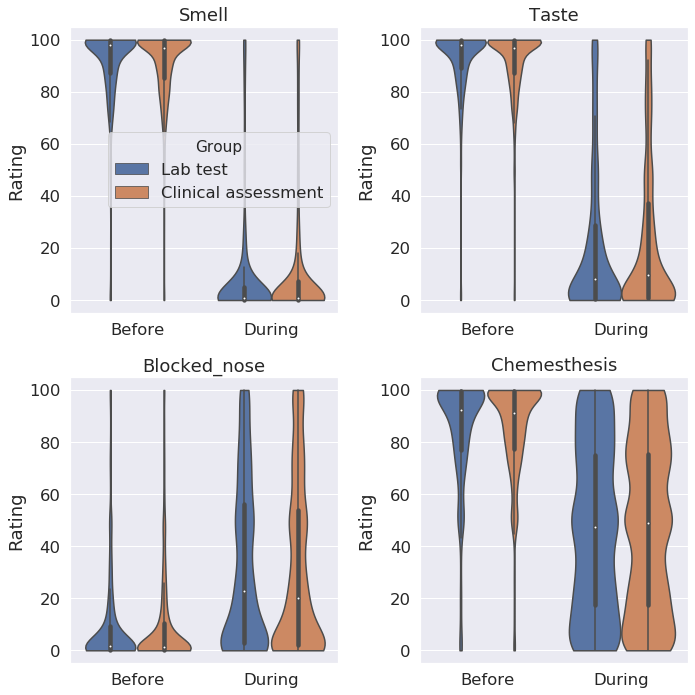

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, sense in enumerate(['Smell', 'Taste', 'Blocked_nose', 'Chemesthesis']):
    make_violin(d, sense, ax=axes.flat[i], legend=(i==0))
plt.tight_layout()

### Figure 4

In [30]:
cols = ['Smell_change', 'smell_loss', 'smell_fluctuations',
        'Nasal_obstruction_change', 'Taste_change', 'Chemesthesis_change']
corrs = d[cols].corr().round(2)
corrs

,Smell_change,smell_loss,smell_fluctuations,Nasal_obstruction_change,Taste_change,Chemesthesis_change
Smell_change,1.00,-0.54,0.03,-0.05,0.44,0.26
smell_loss,-0.54,1.00,-0.24,0.01,-0.26,-0.15
smell_fluctuations,0.03,-0.24,1.00,0.02,0.03,0.00
Nasal_obstruction_change,-0.05,0.01,0.02,1.00,-0.07,-0.09
Taste_change,0.44,-0.26,0.03,-0.07,1.00,0.45
Chemesthesis_change,0.26,-0.15,0.00,-0.09,0.45,1.00


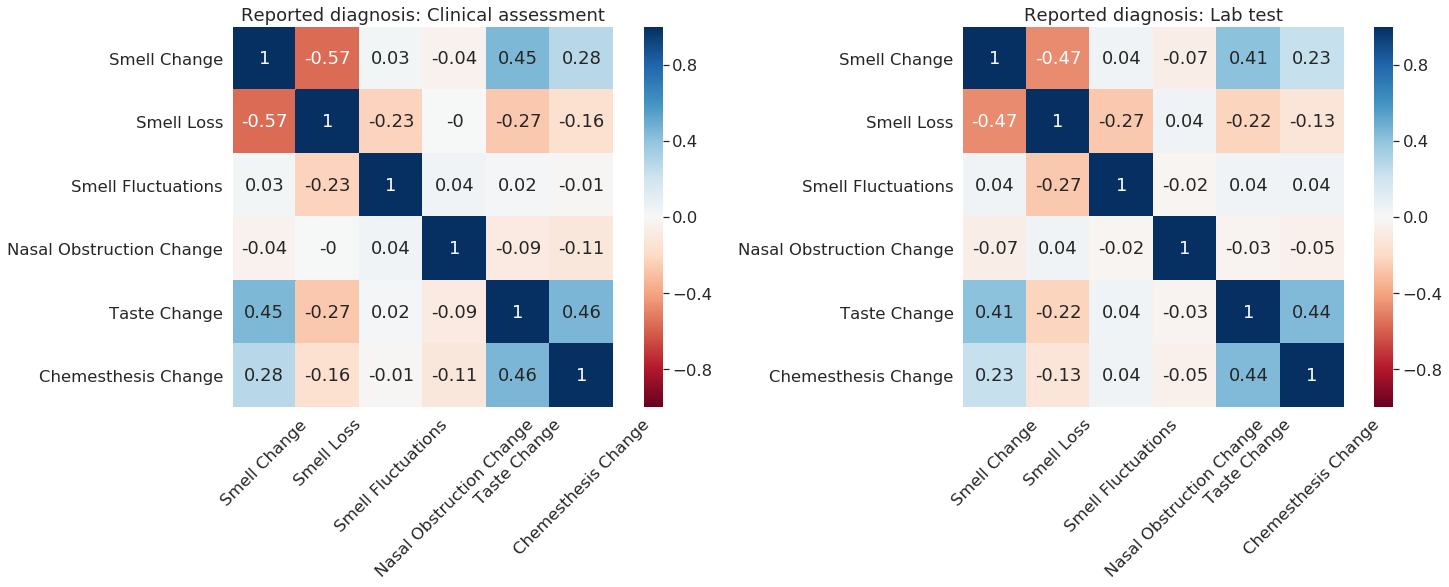

In [31]:
def make_corrmat(d, cols):
    fig, ax = plt.subplots(1, 2, figsize=(24, 7))
    for i, group in enumerate(['Clinical assessment', 'Lab test']):
        d_group = d[d['Group']==group][cols]
        d_group.columns = d_group.columns.str.replace('_',' ').str.title().str.replace('Changes In Basic Tastes ', '')
        corrs = d_group.corr().round(2)
        sns.heatmap(corrs, vmin=-1, vmax=1, cmap='RdBu', square=True, annot=True, ax=ax[i])
        ax[i].set_xticklabels(d_group.columns, rotation=45)
        ax[i].set_title('Reported diagnosis: %s' % group)
        
make_corrmat(d, cols)

### Figure 6 - Chemosensory clustering

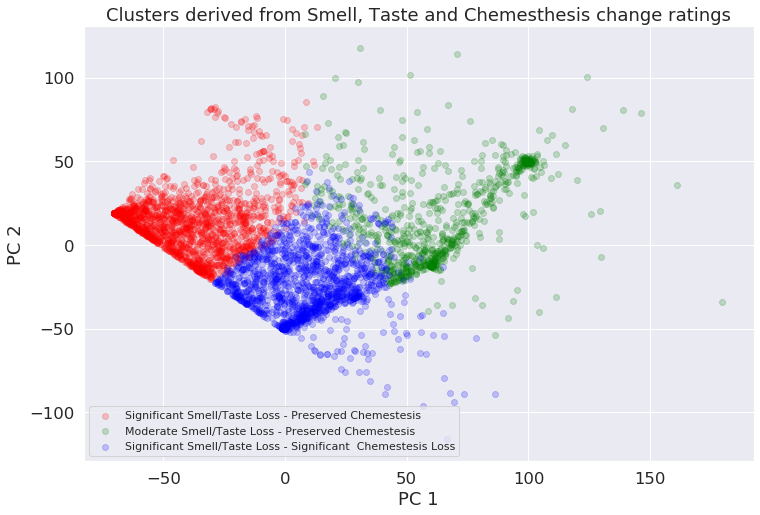

In [32]:
cols = ["Smell_change", "Taste_change", "Chemesthesis_change"]
k = KMeans(n_clusters=3, random_state=123)
pca = PCA(n_components=2)
coords = pca.fit_transform(d[cols])
k.fit(d[cols]);
k.labels_ += 1 # To match R
colors = {1: 'red', 2: 'green', 3: 'blue'}
labels = {1: "Significant Smell/Taste Loss - Preserved Chemestesis",
          2: "Moderate Smell/Taste Loss - Preserved Chemestesis",
          3: "Significant Smell/Taste Loss - Significant  Chemestesis Loss"}
plt.figure(figsize=(12, 8))
for i, color in colors.items():
    plt.scatter(*coords[k.labels_==i].T, c=color, alpha=0.2, label=labels[i])
plt.title('Clusters derived from Smell, Taste and Chemesthesis change ratings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(fontsize=11);

# Supplemental Figures

In [33]:
def make_hist(d, sense, ax, add_legend=True):
    change = '%s_change' % sense
    for group in ['Clinical exam', 'Lab test']:
        d[d['Group']==group][change].hist(bins=50, alpha=0.5, ax=ax, label=group)
    ax.set_xlabel('')
    ax.set_ylabel('Rating')
    ax.set_title('Change in %s' % sense.replace(' ', '').title())
    if add_legend:
        ax.legend()

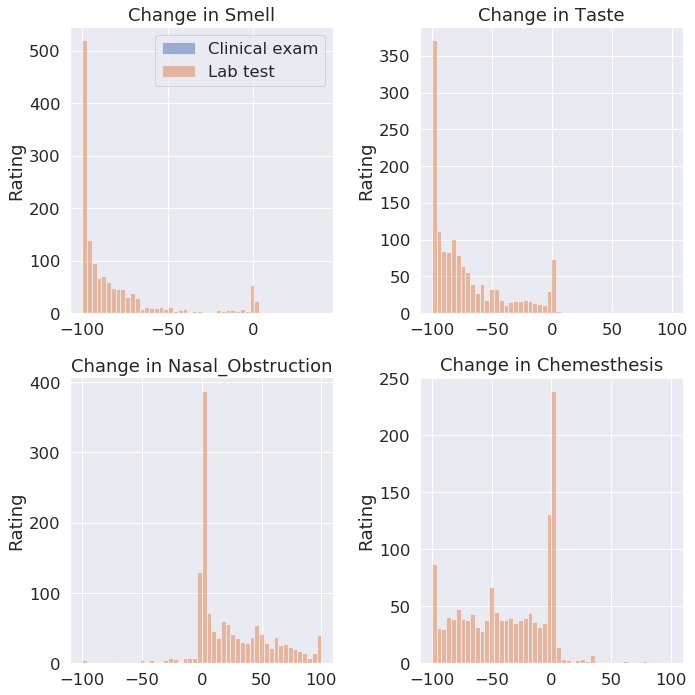

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, sense in enumerate(['Smell', 'Taste', 'Nasal_obstruction', 'Chemesthesis']):
    make_hist(d, sense, ax=axes.flat[i], add_legend=(i==0))
plt.tight_layout()

### Gender by Group

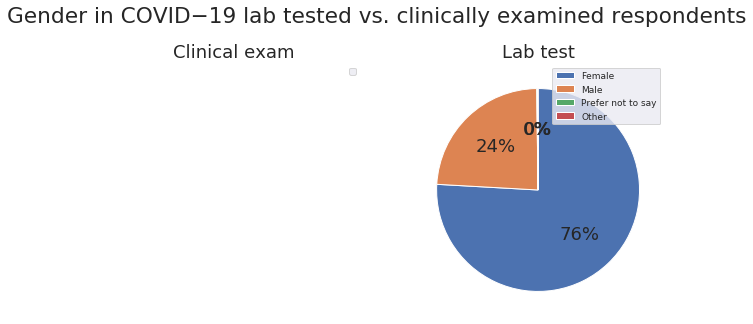

In [35]:
def pie_by_group(d, col):
    fig, axes = plt.subplots(1, 2, figsize=(10, 20))
    plt.suptitle('%s in COVID−19 lab tested vs. clinically examined respondents' % col.title(), y=0.63)
    for i, group in enumerate(['Clinical exam', 'Lab test']):
        d_group = d[d['Group']==group]
        gender = d_group[col].value_counts() / d_group.shape[0]
        labels = d_group[col].value_counts().index
        axes[i].pie(gender, autopct='%1.0f%%', startangle=90, counterclock=False)
        axes[i].set_title(group)
        axes[i].legend(labels, fontsize=9)
        
pie_by_group(d, 'Gender')

### Age by Group

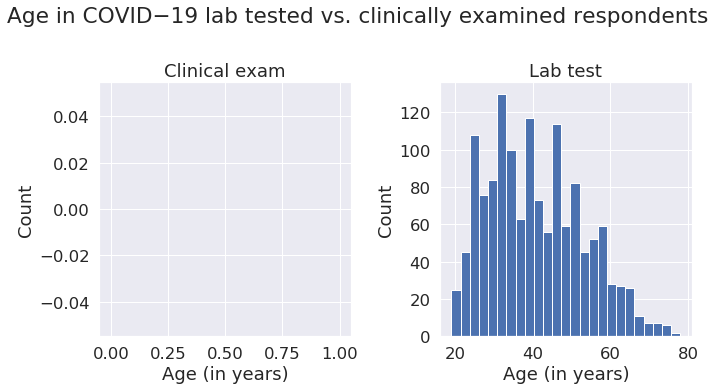

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, group in enumerate(['Clinical exam', 'Lab test']):
    axes[i].hist(d[d['Group']==group]['Age'], bins=25)
    axes[i].set_title(group)
    axes[i].set_xlabel('Age (in years)')
    axes[i].set_ylabel('Count')
plt.suptitle('Age in COVID−19 lab tested vs. clinically examined respondents', y=1.1)
plt.tight_layout()

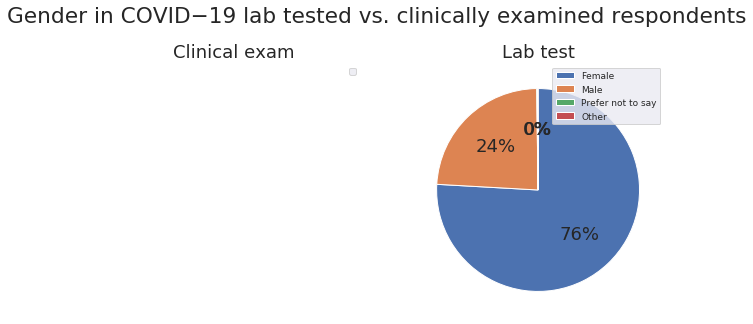

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
plt.suptitle('Gender in COVID−19 lab tested vs. clinically examined respondents', y=0.63)
for i, group in enumerate(['Clinical exam', 'Lab test']):
    d_group = d[d['Group']==group]
    gender = d_group['Gender'].value_counts() / d_group.shape[0]
    labels = d_group['Gender'].value_counts().index
    axes[i].pie(gender, autopct='%1.0f%%', startangle=90, counterclock=False)
    axes[i].set_title(group)
    axes[i].legend(labels, fontsize=9)

### Characterization - Smell Change

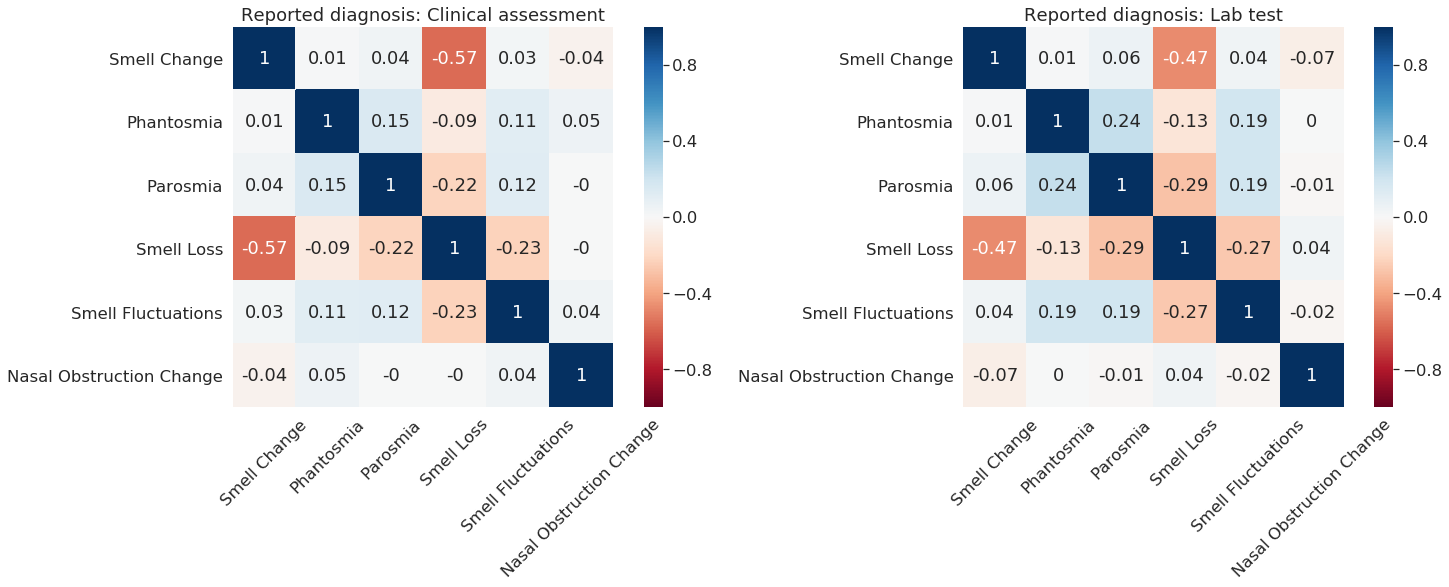

In [38]:
cols = ['Smell_change', 'phantosmia', 'parosmia', 'smell_loss', 'smell_fluctuations', 'Nasal_obstruction_change']
make_corrmat(d, cols)

### Characterization - Taste Change

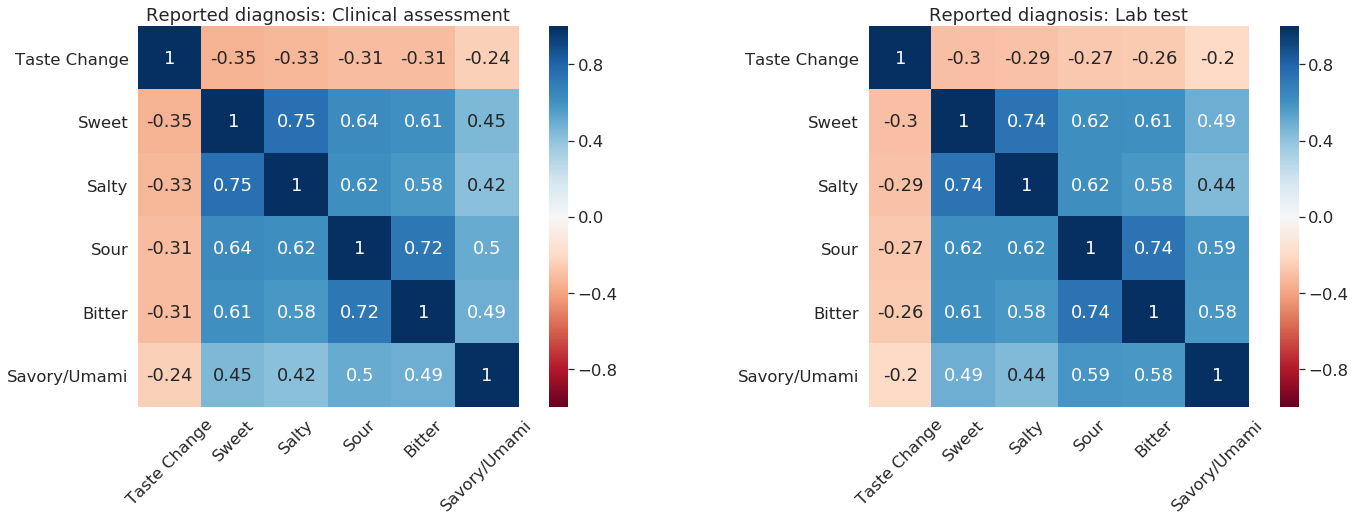

In [39]:
cols = ['Taste_change']
cols += ['Changes_in_basic_tastes_%s' % x for x in ['sweet', 'salty', 'sour', 'bitter', 'savory/umami']]
make_corrmat(d, cols)